In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (13, 9)})

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
from utils import read_pdf, parser_model
from nlp import topic

In [4]:
with open("data/urls-st.txt", "r") as file:
    urls = file.read().split("\n")
    
for url in urls:
    if not read_pdf.is_url(url):
        print(f"Not an url: {url}")

Not an url: https://www.blackrock.com/corporate/literature/publication/blk-annual-stewardship-report-2020.pdf 


In [13]:
text = read_pdf.path_to_sentences(urls[5])

In [14]:
model, corpus, sentences = topic.get_topics(text, num_topics = 50)

In [15]:
def format_topics_sentences(ldamodel, corpus, texts):
    
    sent_topics_df = pd.DataFrame()

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [16]:
df_topic_sents_keywords = format_topics_sentences(model, corpus, sentences)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,18.0,0.9587,"investment, J.P., |, source, apply, ASSET, por...","[George, Gatch, CHIEF, EXECUTIVE, OFFICER, J.P..."
1,1,6.0,0.9915,"company, Global, Head, sustainability, Asset, ...","[J.P., MORGAN, ASSET, MANAGEMENT, |, Foreword,..."
2,2,14.0,0.9844,"investment, stewardship, company, risk, engage...","[paper, pleased, introduce, approach, reinforc..."
3,3,45.0,0.9827,"investment, long, term, believe, stewardship, ...","[Jennifer, Wu, Global, Head, Sustainable, Inve..."
4,4,40.0,0.7830,"company, human, capital, management, diversity...","[investment, stewardship, adhere, set, norm, l..."
5,5,47.0,0.9920,"risk, investment, di˚erent, investor, company,...","[identify, risk, opportunity, substantial, act..."
6,6,27.0,0.9366,"change, risk, company, Head, pose, investment,...","[approach, provide, broad, ˛exibility, datum, ..."
7,7,32.0,0.7741,"term, theme, security, cyber, long, capital, p...","[J.P., MORGAN, ASSET, MANAGEMENT, |, ˚ve, inve..."
8,8,23.0,0.9842,"board, company, key, assess, responsibility, p...","[believe, vital, encourage, high, governance, ..."
9,9,20.0,0.9892,"investor, board, long, term, company, change, ...","[active, investor, demand, high, standard, com..."


In [17]:
def plot_bigrams(sentences, n = 10):
    bigram_tf_idf_vectorizer = TfidfVectorizer(ngram_range=(2,2), use_idf=True)
    bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform([" ".join(sent) for sent in sentences])
    
    words = bigram_tf_idf_vectorizer.get_feature_names()
    
    total_counts = np.zeros(len(words))
    for t in bigram_tf_idf:
        total_counts += t.toarray()[0]
        
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    fig, ax = plt.subplots()
    ax.set_title(f"{n} most common bigrams")
    
    sns.barplot(x_pos, counts, palette="Blues_r", ax = ax)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(words, rotation = 45)
    
    ax.set_xlabel("Bi-grams")
    
    
    return fig,

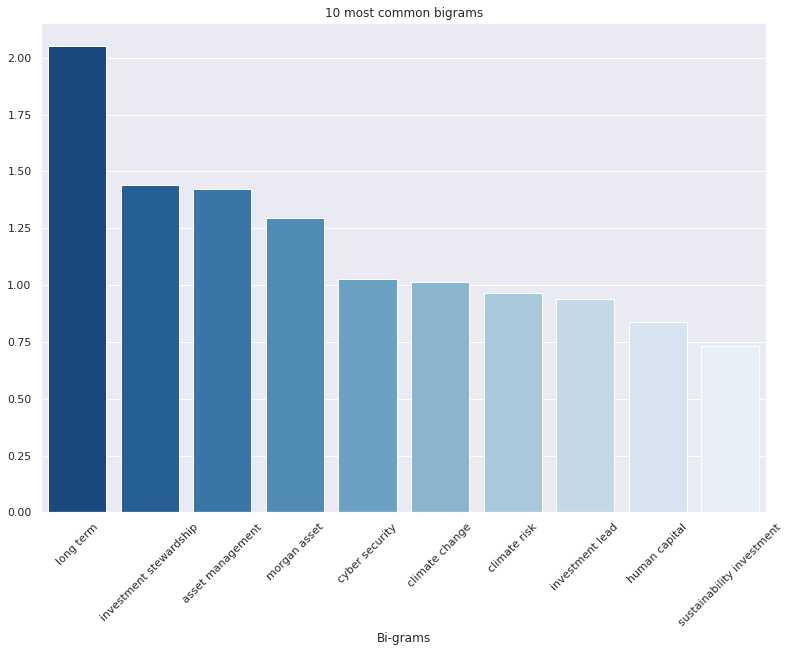

In [18]:
fig = plot_bigrams(sentences, n = 10)